# Deep Learning final project:  DeepRedshift 🤖

*By: Gabriel Missael Barco*

*Professor: Dra. Alma Xochitl González Morales*

The objective of this project is, given the light from a quasar, to predict its redshift. The redshift measures the distance to the quasar, an essential parameter in cosmology.

The data is taken from a simulation provided by the professor and it's composed of 40,000 quasars. An example of the data is shown below:

<center>
<img src="https://i.imgur.com/u4LvPdG.png" width="400"/>
</center>

To assess this problem, we tried two different approaches:
1. Fully connected neural network.
2. Convolutional neural network.

For each of those approaches, we tried different architectures and hyperparameters. We obtained the best results with (surprisingly) a fully connected neural network. The summary of the best result is shown below:

<center>
<img src="https://i.imgur.com/OIhbvqq.png" width="600"/>
</center>

To compare this result, we compare this best run with the results obtained by [Niculas Busca, Christophe Ballan, 2018, _QuasarNET: Human-level spectral classification and redshifting with Deep Neural Networks_ ](https://arxiv.org/abs/1808.09955). Notably, we compare the distribution of the implied velocity difference between the predicted and the real redshift. In summary, this model is **five times worse than QuasarNET in predicting the redshift**.

QuasarNET obtains a $\Delta v = (8 \pm 664)km/s$, and this project $\Delta v = (-40 \pm 2582)km/s$. The difference is huge, but it's important to remember that this model was trained with only 40k examples, while QuasarNET was trained with about half a million examples.

#### Weights & biases magic ✨

We tracked all of the experiments with [Weights and Biases](https://www.wandb.com/). This tool is handy for keeping track of the experiments. The link to the project is [here](https://wandb.ai/gmissaelbarco/QuasarNN?workspace=user-gmissaelbarco). You can see the experiments' results, the code, and the hyperparameters used.

#### How to run the code 🏃‍♂️

To run the code, you need to have [Python 3.9](https://www.python.org/downloads/) and [conda](https://docs.conda.io/en/latest/miniconda.html) installed. Then, you need to create a new environment with the dependencies:

```bash
conda create -n quasar python=3.8
conda activate quasar
conda install --file requirements.txt
```

Then, you can start running the main notebook, and that's it! 🎉. There are two notebooks, this one with all the project details and code explained, and the other one with the code only, `proyecto_final.ipynb`. Part of the code used in the `proyecto_final.ipynb` notebook is in the `DeepRedshift` folder.

Finally, if you prefer to read the report, refer to the `final_report.pdf` file, which was generated with this notebook and Pandoc. Thanks for reading! 🙏

#### References 📚

- [Niculas Busca, Christophe Ballan, 2018, _QuasarNET: Human-level spectral classification and redshifting with Deep Neural Networks_ ](https://arxiv.org/abs/1808.09955)


## Imports 📖

First of all, we import the necessary libraries. We use PyTorch for the neural networks, and other standard libraries for data manipulation and visualization such as Pandas, Numpy, and Matplotlib.

In [35]:
import glob # For reading files
from astropy.io import fits # For reading fits files
import numpy as np # For array operations
import pandas as pd # For dataframes
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
from tqdm import tqdm # For progress bars
import os # For reading paths
import logging # For logging
import wandb # To keep track of experiments
import scipy.stats as stats # For statistical tests

# Pytroch modules for neural networks
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from torchinfo import summary

# Show selected GPU
gpu_idx = torch.cuda.current_device()
print(torch.cuda.get_device_properties(gpu_idx))

# Read the wavelength array (same for all spectra)
wv = pd.read_csv('data/QSOs/0.csv')['wave'].values

# For reproducibility
torch.manual_seed(42)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Wandb config
os.environ["WANDB_SILENT"] = "true"

# Figure style
sns.set_theme()

# Logger
logger = logging.getLogger('wandb')
logger.setLevel(logging.ERROR)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)


## Pre-process data ⚙️

Before start working on the neural networks, we need to pre-process the data. The data is composed of 40,000 quasars, with three bands: $u$, $g$, and $r$. Each band corresponds to different wavelengths. Let's take a look at the data:

In [37]:
# Read all the data
df = pd.read_pickle('data/data.pkl')

The QSO simulations contains a lot of information, but we only selected the information shown below.

In [38]:
# Show dataframe structure
df.head(3)

,flux_full,Z,flux_b,wave_b,flux_r,wave_r,flux_z,wave_z
50130291,5.5749,1.847688,"[6.316943645477295, 4.637505054473877, 4.45759...","[3569.39990234375, 3570.39990234375, 3571.3999...","[0.8951932787895203, -0.48711779713630676, 6.2...","[5625.39990234375, 5626.39990234375, 5627.3999...","[1.343870759010315, 2.467992067337036, 4.08662...","[7435.39990234375, 7436.39990234375, 7437.3999..."
50130304,4.427626,1.817459,"[3.4335825443267822, 1.9359098672866821, 3.305...","[3569.39990234375, 3570.39990234375, 3571.3999...","[-1.2831424474716187, -0.7486328482627869, 0.2...","[5625.39990234375, 5626.39990234375, 5627.3999...","[0.5637927651405334, 1.4473059177398682, 2.588...","[7435.39990234375, 7436.39990234375, 7437.3999..."
50130318,4.652752,1.940764,"[22.567916870117188, 24.14146614074707, 19.105...","[3569.39990234375, 3570.39990234375, 3571.3999...","[0.07029576599597931, -7.117312908172607, -3.0...","[5625.39990234375, 5626.39990234375, 5627.3999...","[2.164449691772461, 0.7670164704322815, -1.800...","[7435.39990234375, 7436.39990234375, 7437.3999..."


We are interested in predicting the redshift. Here is the distribution of the redshift:

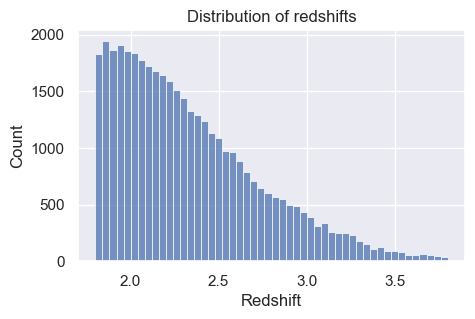

Min redshift: 1.800
Max redshift: 3.800


In [44]:
# Distribution of redshifts
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.histplot(df['Z'], ax=ax, bins=50)
ax.set_xlabel('Redshift')
ax.set_ylabel('Count')
ax.set_title('Distribution of redshifts')
plt.show()

# Print range of redshifts
print('Min redshift: {:.3f}'.format(df['Z'].min()))
print('Max redshift: {:.3f}'.format(df['Z'].max()))

An example of the data is shown below:

Text(0.5, 1.0, 'Quasar spectrum example - Redshift: z = 1.8477')

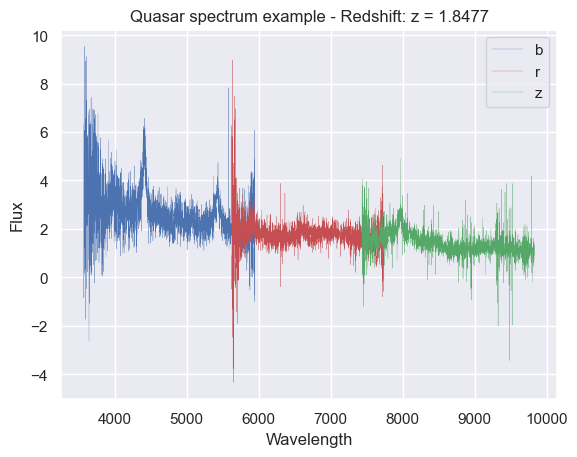

In [13]:
# Select one quasar
df_row = df.iloc[0]

# Extract data
flux_b = df_row['flux_b']
wave_b = df_row['wave_b']
flux_r = df_row['flux_r']
wave_r = df_row['wave_r']
flux_z = df_row['flux_z']
wave_z = df_row['wave_z']
z = df_row['Z']

# Generate plot
plt.plot(wave_b, flux_b, color = 'b', linewidth = 0.2, label = 'b')
plt.plot(wave_r, flux_r, color = 'r', linewidth = 0.2, label = 'r')
plt.plot(wave_z, flux_z, color = 'g', linewidth = 0.2, label = 'z')
plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(f'Quasar spectrum example - Redshift: z = {z:.4f}')

We could try to work with the three bands as they are, but we decided to merge them into a single band, and preserve the sequiential information they have. To do this, we simple choose the middle point between two consecutive bands. An example of this process is shown below:

Text(0.5, 1.0, 'Example of merged bands - Redshift: z = 1.8477')

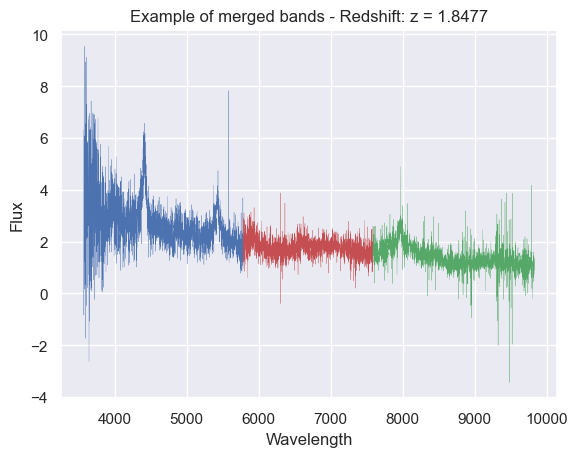

In [14]:
# Middle points of the wavelength ranges
delta_br = (wave_b[-1] + wave_r[0]) / 2
delta_rz = (wave_r[-1] + wave_z[0]) / 2

# New flux and wavelength arrays
flux_b = flux_b[:np.where(delta_br < wave_b)[0][0]]
wave_b = wave_b[:np.where(delta_br < wave_b)[0][0]]
flux_r = flux_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
wave_r = wave_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
flux_z = flux_z[np.where(delta_rz > wave_z)[0][-1]:]
wave_z = wave_z[np.where(delta_rz > wave_z)[0][-1]:]

# Plot result
plt.plot(wave_b, flux_b, color = 'b', linewidth = 0.2)
plt.plot(wave_r, flux_r, color = 'r', linewidth = 0.2)
plt.plot(wave_z, flux_z, color = 'g', linewidth = 0.2)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(f'Example of merged bands - Redshift: z = {z:.4f}')

And finally, once we concatenate the three bands, we have only one array of sequential data for each spectrum.

(6267,)


Text(0.5, 1.0, 'Example of concatenated bands - Redshift: z = 1.8477')

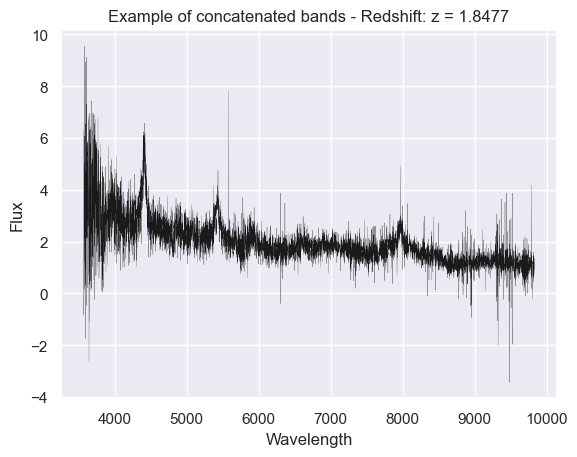

In [15]:
# Concatenate
flux = np.concatenate((flux_b, flux_r, flux_z))
wave = np.concatenate((wave_b, wave_r, wave_z))

plt.plot(wave, flux, color = 'k', linewidth = 0.15)
print(flux.shape)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(f'Example of concatenated bands - Redshift: z = {z:.4f}')

As we can see, each spectra has 6267 wavelenth bins. Finally, we do this process for all the spectra and save the result in a new file.

In [16]:
# Create lists to store data
Z = []
ids = []
flux_full = []
flux = []
wv = []

# Iterate over all the rows
for i in tqdm(range(0, len(df))):
    # Get i-th row
    df_row = df.iloc[i]

    # Extract data
    flux_b = df_row['flux_b']
    wave_b = df_row['wave_b']
    flux_r = df_row['flux_r']
    wave_r = df_row['wave_r']
    flux_z = df_row['flux_z']
    wave_z = df_row['wave_z']
    Z.append(df_row['Z'])
    ids.append(df_row.name)
    flux_full.append(df_row['flux_full'])

    # Middle points of the wavelength ranges
    delta_br = (wave_b[-1] + wave_r[0]) / 2
    delta_rz = (wave_r[-1] + wave_z[0]) / 2

    # New flux and wavelength arrays
    flux_b = flux_b[:np.where(delta_br < wave_b)[0][0]]
    wave_b = wave_b[:np.where(delta_br < wave_b)[0][0]]
    flux_r = flux_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
    wave_r = wave_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
    flux_z = flux_z[np.where(delta_rz > wave_z)[0][-1]:]
    wave_z = wave_z[np.where(delta_rz > wave_z)[0][-1]:]

    # Concatenate
    flux_i = np.concatenate((flux_b, flux_r, flux_z))
    wave_i = np.concatenate((wave_b, wave_r, wave_z))

    # Append to lists
    flux.append(flux_i)
    wv.append(wave_i)

100%|██████████| 40000/40000 [00:17<00:00, 2259.05it/s]


In [17]:
# Create new dataframe with processed data
data = {'id': ids, 'Z': Z, 'flux_full': flux_full, 'flux': flux, 'wave': wv}
df = pd.DataFrame(data)
df.head()

,id,Z,flux_full,flux,wave
0,50130291,1.847688,5.574900,"[6.316943645477295, 4.637505054473877, 4.45759...","[3569.39990234375, 3570.39990234375, 3571.3999..."
1,50130304,1.817459,4.427626,"[3.4335825443267822, 1.9359098672866821, 3.305...","[3569.39990234375, 3570.39990234375, 3571.3999..."
2,50130318,1.940764,4.652752,"[22.567916870117188, 24.14146614074707, 19.105...","[3569.39990234375, 3570.39990234375, 3571.3999..."
3,50130322,2.279219,4.309511,"[3.3110246658325195, 1.6816339492797852, 9.821...","[3569.39990234375, 3570.39990234375, 3571.3999..."
4,50130325,2.290676,12.221321,"[1.4321434497833252, 13.602473258972168, 2.557...","[3569.39990234375, 3570.39990234375, 3571.3999..."


In [18]:
# If data is not saved, save it
if not os.path.exists('data/data_ready.pkl'):
    df.to_pickle('data/data_ready.pkl')

## Resample the data 🤔

Each quasar has a lot of wavelength bins. Furthermore, high variation in the flux in each bin can reduce performance and affect training. Because of this, we decided to create a second dataset with a lower resolution. We resample the data to about 500 bins. For that, we created the next function:

In [20]:
def rebin_data (wv, fluxes, bin_size = None):
    """Rebin data to a new bin size.

    Parameters
    ----------
    wv : array
        Wavelength array.
    fluxes : array
        Flux array.
    bin_size : float, optional
        New bin size. If None, the original bin size is used.

    Returns
    -------
    wv : array
        New wavelength array.
    fluxes : array
        New flux array.
    """

    # Change bin size
    new_bin_size = bin_size

    # Original bin size with one decimal place
    original_bin_size = wv[1] - wv[0]
    original_bin_size = round(original_bin_size, 1)

    # Number of bins to average over
    stack_number = new_bin_size / original_bin_size

    # Check if the number of bins to average over is an integer
    if abs(stack_number - round(stack_number)) > 0.00001:
        raise ValueError(f'New bin size {new_bin_size} must be a'\
            +f' multiple of the original bin size {original_bin_size:.3f}')

    # Ceil to first integer
    stack_number = int(round(stack_number))

    # New wavelength array
    wv = np.arange(wv[0], wv[-1] + bin_size, bin_size)

    # Remove extra bins from the fluxes
    remove = len(fluxes[0]) % stack_number
    if remove != 0:
        fluxes = fluxes[:, :-remove]

    # Reshape the flux array
    fluxes = fluxes.reshape(len(fluxes), -1, stack_number)

    # Average over the last axis
    fluxes = np.mean(fluxes, axis=-1)

    # Make wv and fluxes the same shape
    n_bins = len(fluxes[0])
    wv = wv[:n_bins]

    return wv, fluxes

Here is an example of a resampled spectrum:

Current bin size: 1.000
Current data shape: (6267,)
New bin size: 8.000
New data shape: (783,)


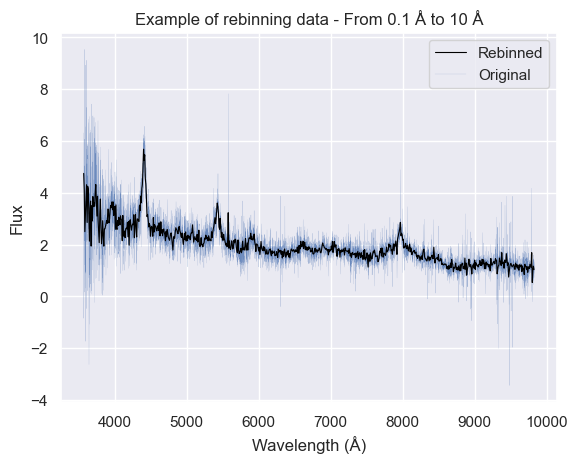

In [21]:
# Print current bin size and data shape
print(f'Current bin size: {wv[0][1] - wv[0][0]:.3f}')
print(f'Current data shape: {flux[0].shape}')

# New bin size
new_bin_size = 8.0

# Rebin data
wv_example, flux_example = rebin_data(wv[0], np.array([flux[0]]),
                                    bin_size = new_bin_size)

# Print new bin size and data shape
print(f'New bin size: {wv_example[1] - wv_example[0]:.3f}')
print(f'New data shape: {flux_example[0].shape}')

# Plot new data and old data
plt.plot(wv_example, flux_example[0], linewidth = 0.8, zorder = 5, 
        label = 'Rebinned', color = 'black')
plt.plot(wv[0], flux[0], linewidth = 0.1, alpha = 0.8, label = 'Original')
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('Example of rebinning data - From 0.1 Å to 10 Å')
plt.show()

It can be seen that the resolution is lower, but the important information is preserved (such as the peaks). Now, we create our second dataset with the resampled data.

In [2]:
# Rebinn all data

# if dont exist, create
if not os.path.exists('data/data_rebinned.pkl'):
    # Copy dataframe
    df_rebinned = df.copy()

    # Apply rebinning function
    df_rebinned['wave_rebinned'] = df_rebinned.apply(lambda x: \
        rebin_data(x['wave'], np.array([x['flux']]), bin_size = 10.0)[0], axis = 1)
    df_rebinned['flux_rebinned'] = df_rebinned.apply(lambda x: \
        rebin_data(x['wave'], np.array([x['flux']]), bin_size = 10.0)[1][0], axis = 1)

    # Drop old columns
    df_rebinned = df_rebinned.drop(columns = ['wave', 'flux'])

    # Rename columns
    df_rebinned = df_rebinned.rename(columns = \
        {'wave_rebinned': 'wave', 'flux_rebinned': 'flux'})

    # Save dataframe to pkl
    df_rebinned.to_pickle('data/data_rebinned.pkl')

    del df_rebinned

del df

## Create Pytorch dataset 🧠

Now that our data is ready, we can create our custom Pytorch dataset. We create a class that inherits from `torch.utils.data.Dataset`. This class has two methods: `__len__` and `__getitem__`. The first one returns the length of the dataset, and the second one returns the data at a given index. At this step, we also split the data into training, validation, and test sets, with a 0.8, 0.1, and 0.1 ratio, respectively, for the training, validation, and test sets.

In [26]:
# Define dataset
class QuasarDataset(Dataset):
    """Quasar dataset.

    Parameters
    ----------
    data_path : str
        Path to the data.
    transform : callable, optional
        Optional transform to be applied on a sample.
    target_transform : callable, optional
        Optional transform to be applied on the target.

    Attributes
    ----------
    labels : array
        Array of labels (redshifts)
    data : array
        Array of data (fluxes)
    transform : callable
        Transform to be applied on a sample.
    target_transform : callable
        Transform to be applied on the target.

    Methods
    -------
    __len__()
        Return the length of the dataset.
    __getitem__(idx)
        Return the sample and label at index idx.
    """
    def __init__(self, data_path, transform=None,
        target_transform=None):
        # read pkl with data
        aux = pd.read_pickle(data_path)

        # get labels and data
        self.labels = aux['Z']
        self.data = aux['flux']

        # delete aux to free memory
        del aux

        # set transforms
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # return length of dataset
        return len(self.labels)

    def __getitem__(self, idx):
        # Check if idx is a tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read data
        quasar = self.data[idx]

        # Read label
        label = self.labels[idx]

        # Transform data
        if self.transform:
            quasar = self.transform(quasar)

        # Transform label
        if self.target_transform:
            label = self.target_transform(label)

        # Return quasar, label
        return quasar, label

With our Dataset class ready, we create our dataset for the normal and resampled data.

In [28]:
# Create dataset
dataset = QuasarDataset(data_path='data/data_ready.pkl')

# Train/val/test split
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

# Print sizes
print(f'Size of train set: {len(train_set)}')
print(f'Size of validation set: {len(val_set)}')
print(f'Size of test set: {len(test_set)}')

Size of train set: 32000
Size of validation set: 4000
Size of test set: 4000


In [32]:
# Rebinned dataset
dataset_rebinned = QuasarDataset(data_path='data/data_rebinned.pkl')

# Train/val/test split
train_set_rebin, val_set_rebin, test_set_rebin = \
    random_split(dataset_rebinned, [0.8, 0.1, 0.1])

print(f'Size of train set: {len(train_set_rebin)}')
print(f'Size of validation set: {len(val_set_rebin)}')
print(f'Size of test set: {len(test_set_rebin)}')

Size of train set: 32000
Size of validation set: 4000
Size of test set: 4000


We can access the data with the `__getitem__` method. For example, we can access the fifth element of the dataset with:

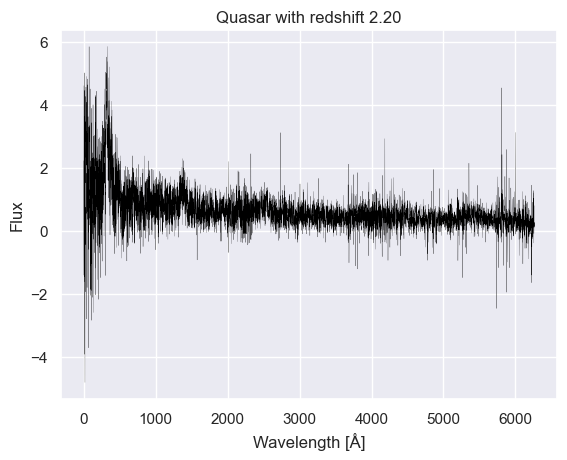

Shape of quasar: (6267,)
Size of dataset: 40000


In [33]:
# Example
quasar, label = dataset[5]

plt.plot(quasar, linewidth=0.15, color = 'black')
plt.title(f'Quasar with redshift {label:.2f}')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.show()

print(f'Shape of quasar: {quasar.shape}')
print(f'Size of dataset: {len(dataset)}')

Same with the resampled dataset:

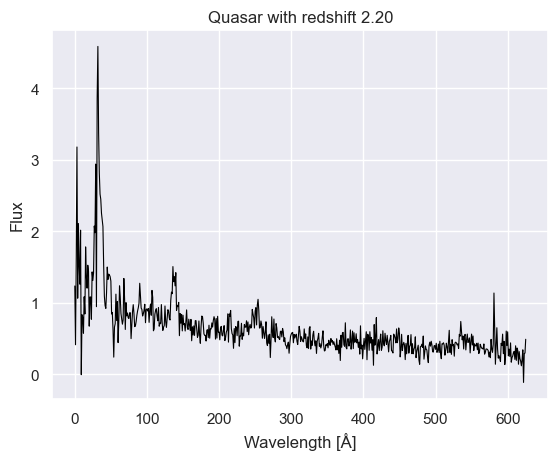

Shape of quasar: (626,)
Size of dataset: 40000


In [34]:
# Example
quasar, label = dataset_rebinned[5]

plt.plot(quasar, color = 'black', linewidth = 0.8)
plt.title(f'Quasar with redshift {label:.2f}')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.show()

print(f'Shape of quasar: {quasar.shape}')
print(f'Size of dataset: {len(dataset)}')

## Report plots 📊



Befor start creating and training models, we need an intelligent way to compare the results. For that, we created a function that takes the predicted and real redshifts, the training and validation losses, the model metrics, and the hyperparameters used. This function generates a report with the results, and saves it in a file. This function is shown below:

In [45]:
def report_plot(labels, predictions, train_losses, val_losses, config, metrics_values):
    """Plot model details, performance and losses.

    Parameters
    ----------
    labels : array
        Array of labels (redshifts).
    predictions : array
        Array of predictions (redshifts).
    train_losses : array
        Array of train losses.
    val_losses : array
        Array of validation losses.
    config : dict
        Dictionary with model configuration.
    metrics_values : dict
        Dictionary with model metrics.

    Returns
    -------
    None
    """
    # Create figure
    fig = plt.figure(constrained_layout = True, figsize=(8, 11))

    # Create subfigures for different plots
    subfigs = fig.subfigures(4, 1, wspace=0.05, hspace=0.01,
        width_ratios=[1], height_ratios=[0.6, 1.5, 1, 1.5])

    # Set titles
    subfigs[0].suptitle(f'Model details, hyperparemeters and metrics', fontsize=20)
    subfigs[1].suptitle('Model performance', fontsize=16)
    subfigs[2].suptitle('Error distribution', fontsize=16)
    subfigs[3].suptitle('Losses', fontsize=16)

    # write model details
    ax_details = subfigs[0].subplots(1, 1)
    ax_details.axis('off')
    t = (
        f'Model type = {config["model_type"]} - {config["layers_dims"]}\n' + \
        f'Learning rate = {config["learning_rate"]}, epochs = {config["epochs"]}, ' + \
        f'Batch size = {config["batch_size"]}, Dropout = {config["dropout"]}\n' + \
        f'MAE = {metrics_values["mae"]:.6f}, MSE = {metrics_values["mse"]:.6f}, ' + \
        f'CCC = {metrics_values["ccc"]:.6f}, R2 = {metrics_values["r2"]:.6f}'
    ).expandtabs()
    ax_details.text(0.5, 0.5, t, fontsize=13, verticalalignment='center',
                    horizontalalignment='center', wrap = True,
                    bbox=dict(facecolor='#EAEAF2', boxstyle='round', pad=1))

    # Plot performance
    ax_perf = subfigs[1].subplots(1, 2)

    # Plot error distribution
    mean = np.mean(np.abs(labels - predictions))
    std = np.std(np.abs(labels - predictions))
    ax_perf[0].scatter(labels, predictions, s=10, alpha = 0.2, color = 'green')
    ax_perf[0].plot([-1, 6], [-1, 6], color='black', linestyle='--', zorder=10)
    ax_perf[0].set_xlim(min(labels)- 0.1, max(labels) + 0.1)
    ax_perf[0].set_ylim(min(labels)-0.1, max(labels)+0.1)
    ax_perf[0].set_title('Predicted vs. actual redshift')
    ax_perf[0].set_xlabel('Real redshift')
    ax_perf[0].set_ylabel('Predicted redshift')

    idx_sort = np.argsort(labels)

    delta_vel = (labels - predictions)/(1+labels)*300_000
    delta_vel_mean = np.mean(delta_vel)
    delta_vel_std = np.std(delta_vel)

    # 50 bins with 3 std
    bins = np.linspace(-2.5*delta_vel_std, 2.5*delta_vel_std, 50)

    hist = ax_perf[1].hist(delta_vel, bins = bins,
        color = 'blue', alpha = 0.5, label = 'This', density = True,
        histtype = 'stepfilled')
    # Set ylimit with highest bin
    ax_perf[1].set_ylim(0, max(hist[0]))

    # Set xlim to 3 std
    ax_perf[1].set_xlim(-2.5*delta_vel_std, 2.5*delta_vel_std)

    # Plot error distribution from quasarNet
    # mean = 8, std = 664
    aux = np.linspace(-3000,  3000, 1000)
    ax_perf[1].plot(aux, stats.norm.pdf(aux, 8, 664),
        color = 'black', label = 'QuasarNet', linestyle = '--', linewidth = 2)

    ax_perf[1].set_xlabel('$\Delta v$ [km/s]')
    ax_perf[1].set_ylabel('Density')
    ax_perf[1].set_title(f'$\Delta v$ = {delta_vel_mean:.2f}'+ \
        ' $\pm$ {delta_vel_std:.2f} km/s')
    ax_perf[1].legend()

    # Plot error distribution
    ax_err = subfigs[2].subplots(1, 1)

    ax_err.plot(labels[idx_sort] - predictions[idx_sort], linewidth=0.3, color = 'black')
    ax_err.set_ylabel('$\Delta Z$')
    ax_err.set_xlabel('Quasar index')
    ax_err.set_ylim(-1, 1)

    # Plot losses
    ax_loss = subfigs[3].subplots(1, 2)
    ax_loss[1].plot(val_losses, label='Validation loss')
    ax_loss[1].plot(train_losses, label='Train loss')
    ax_loss[1].set_yscale('log')
    ax_loss[1].legend()
    ax_loss[1].set_xlabel('Epoch')
    ax_loss[1].set_ylabel('Loss')

    ax_loss[0].plot(val_losses, label='Validation loss')
    ax_loss[0].plot(train_losses, label='Train loss')
    ax_loss[0].legend()
    ax_loss[0].set_xlabel('Epoch')
    ax_loss[0].set_ylabel('Loss')
    return fig


We can see an example of the report below (with random data):

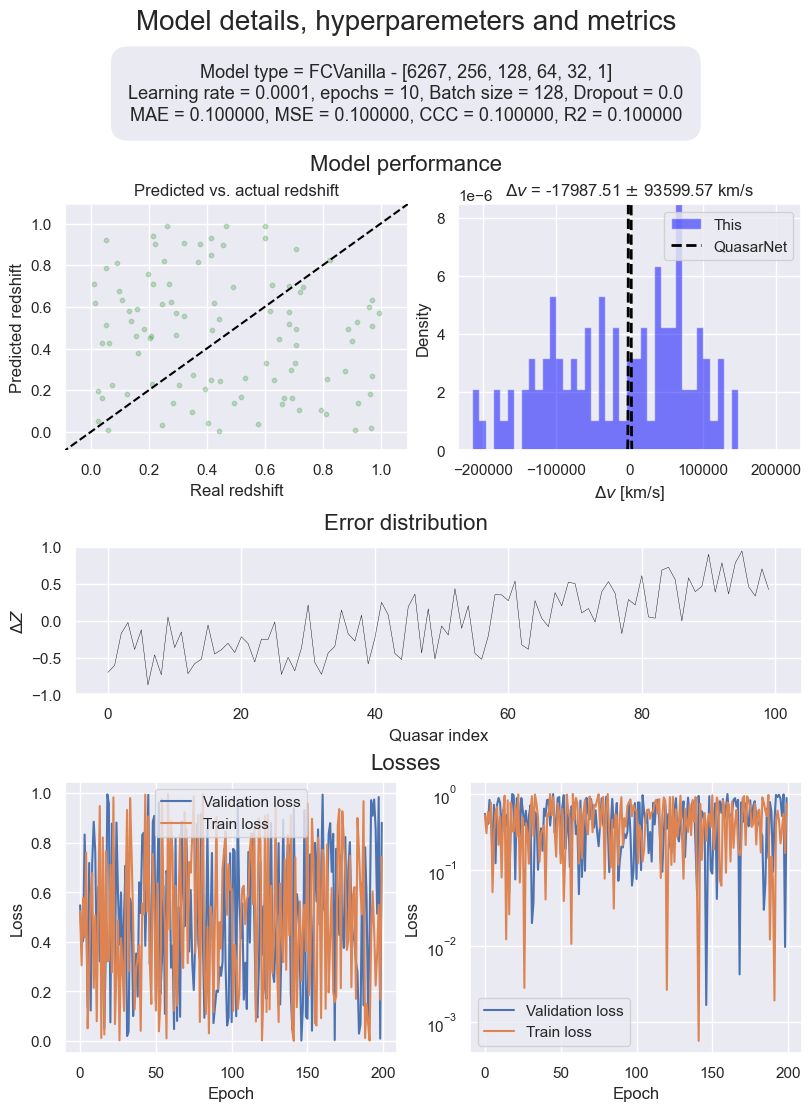

In [46]:
# Random values
labels = np.random.rand(100)
predictions = np.random.rand(100)
val_loss = np.random.rand(200)
train_loss = np.random.rand(200)

config_fc = {
    'epochs': 10,
    'batch_size': 128,
    'learning_rate': 0.0001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 256, 128, 64, 32, 1]
}

metrics_values = {
    'mae': 0.1,
    'mse': 0.1,
    'ccc': 0.1,
    'r2': 0.1
}

report = report_plot(labels, predictions, train_loss, val_loss, config_fc, metrics_values)

## Model architectures 🧱


In [28]:
# Plumbing all the models
model_fc_vanilla = FCVanilla(layers_dims=[6267, 1024, 256, 64, 16, 1])
model_fc_batchnorm_dropout = FCBatchNormDropout(layers_dims=[6267, 1024,
    256, 64, 16, 1], dropout=0.2)

x = torch.randn(10, 6267, dtype = torch.float32)
try:
    model_fc_vanilla(x)
    model_fc_batchnorm_dropout(x)
except Exception as e:
    print(e)

In [29]:
# Ploombing the models with random data
x = torch.randn(10, 6267, dtype = torch.float32)

model_cnn_vanilla = CNNVanilla()
model_cnn_deep = CNNDeep()

try:
    model_cnn_vanilla(x)
    model_cnn_deep(x)
    print("Success!")
except Exception as e:
    print(e)

Success!


In [30]:
config_fc_template = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 256, 128, 64, 32, 1]
}

# Fully connected network

100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


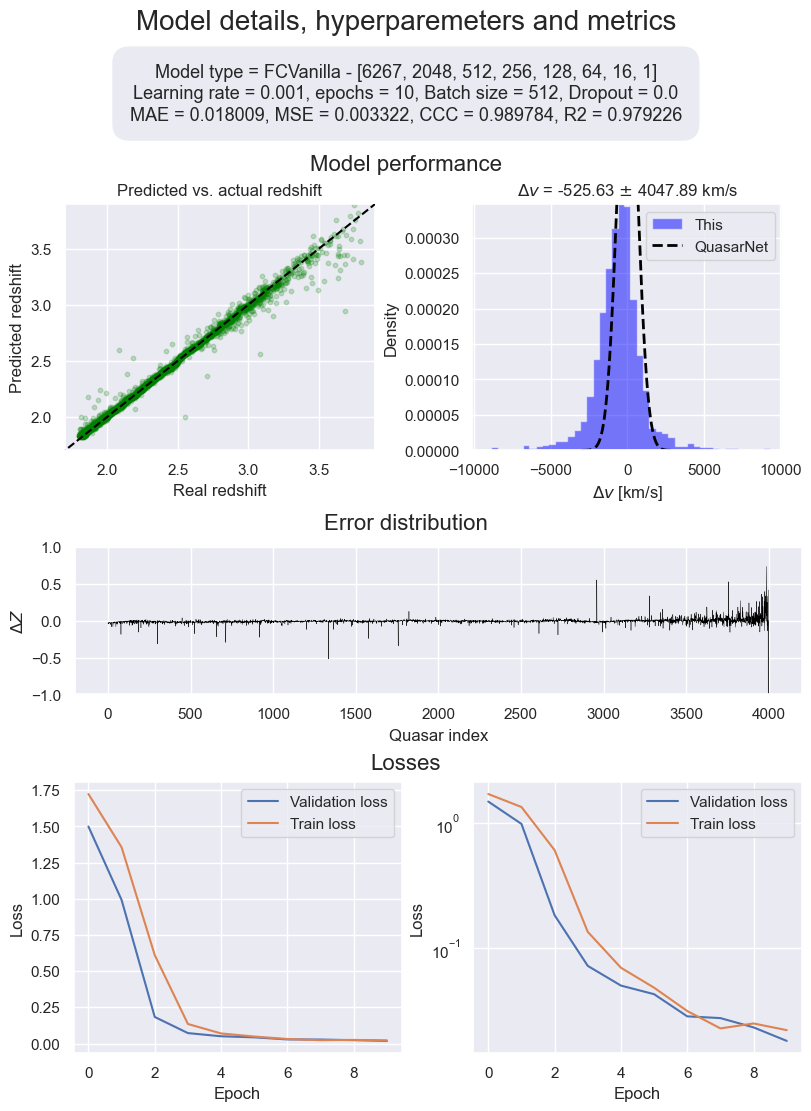

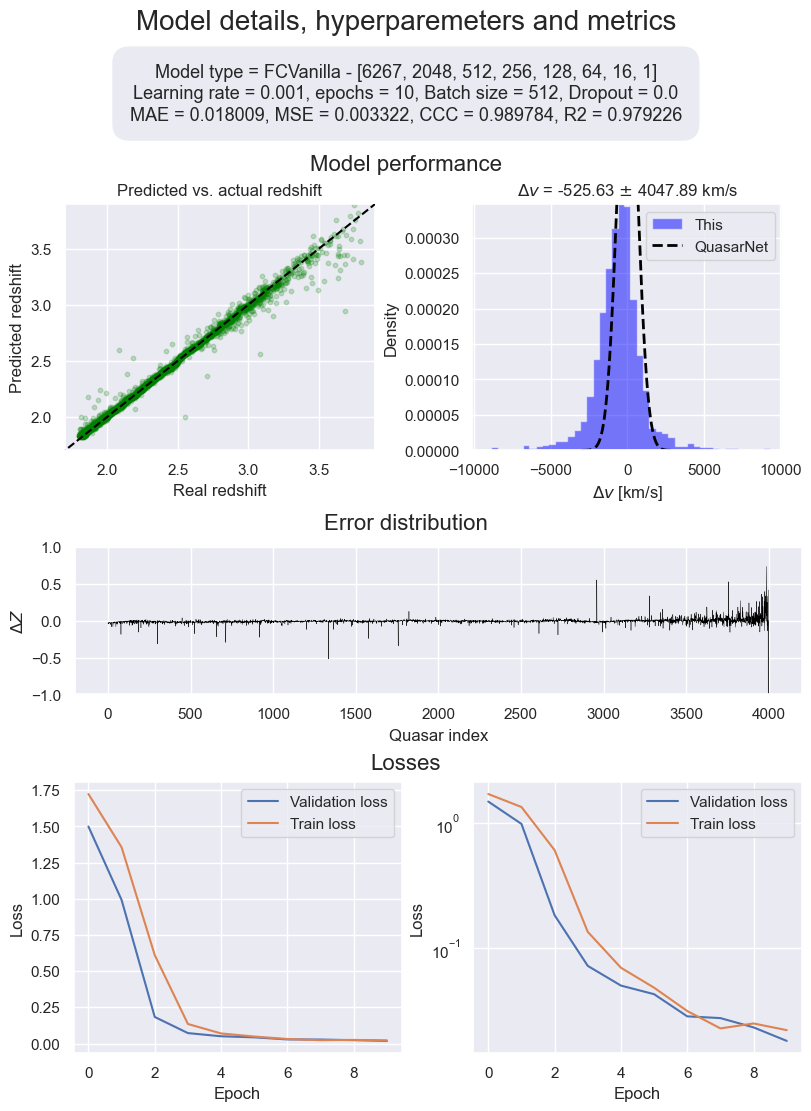

In [10]:
config_fc = {
    'epochs': 10,
    'batch_size': 512,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 2048, 512, 256, 128, 64, 16, 1]
}

# Create model with seed
torch.manual_seed(42)
model = FCVanilla(config_fc['layers_dims'])
model_try(config_fc, model, train_set, val_set)

In [ ]:
config_fc = {
    'epochs': 60,
    'batch_size': 256,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 4096, 2048, 1024, 512, 256, 128, 64, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 1]
}

# Create model with seed
torch.manual_seed(42)
model = FCVanilla(config_fc['layers_dims'])
model_try(config_fc, model, train_set, val_set)

In [ ]:
# 36 Modelos diferentes!
possible_epochs = [50]
possible_batch_sizes = [64, 128, 256]
possible_learning_rates = [0.001, 0.0005, 0.0001]
possible_layers_dims = [
    [6267,4096,2048,1024,512,256,128,64,32,1],
    [6267,4096,2048,1024,512,256,128,64,64,64,64,64,64,64,64,64,64,64,32,1],
    [6267,4096,2048,1024,512,256,128,64,32,32,32,32,32,32,32,32,32,32,16,1],
    [6267,4096,2048,2048,1024,1024,512,512,512,256,256,256,128,128,128,128,64,64,64,64,32,32,32,32,1],
]

for epochs in possible_epochs:
    for batch_size in possible_batch_sizes:
        for learning_rate in possible_learning_rates:
            for layers_dims in possible_layers_dims:
                config_fc = {
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'learning_rate': learning_rate,
                    'dropout': 0.0,
                    'model_type': 'FCVanilla',
                    'layers_dims': layers_dims
                }

                # Create model with seed
                torch.manual_seed(42)
                model = FCVanilla(config_fc['layers_dims'])
                model_try(config_fc, model, train_set, val_set)

### Try in rebin data

In [ ]:
config_fc = {
    'epochs': 60,
    'batch_size': 128,
    'learning_rate': 0.0005,
    'dropout': 0.0,
    'model_type': 'FCVanilla_rebin',
    'layers_dims': [6267,4096,2048,1024,512,256,128,64,64,64,64,64,64,64,64,64,64,64,32,1]
}

# Create model with seed
model = FCVanilla(config_fc['layers_dims'])
model_try(config_fc, model, train_set_rebin, val_set_rebin)

### Try with BatchNorm and Dropout (whithout rebin)

In [ ]:
config_fc = {
    'epochs': 60,
    'batch_size': 128,
    'learning_rate': 0.0005,
    'dropout': 0.0,
    'model_type': 'FCBatchNormDropout',
    'layers_dims': [6267,4096,2048,1024,512,256,128,64,64,64,64,64,64,64,64,64,64,64,32,1]
}

# Create model with seed
model = FCBatchNormDropout(config_fc['layers_dims'])
model_try(config_fc, model, train_set, val_set)

# Convolutional neural network

In [22]:
class QuasarNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.type = 'CNNVanilla'
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 100, kernel_size = 10, stride = 2, padding = 'valid'),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Conv1d(in_channels = 100, out_channels = 100, kernel_size = 10, stride = 2, padding = 'valid'),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Conv1d(in_channels = 100, out_channels = 100, kernel_size = 10, stride = 2, padding = 'valid'),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Conv1d(in_channels = 100, out_channels = 100, kernel_size = 10, stride = 2, padding = 'valid'),
            nn.BatchNorm1d(100),
            nn.ReLU(),
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3100, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        # Add empty channel dimension
        x = x.unsqueeze(1)

        x = self.conv_relu_stack(x)

        x = self.flatten(x)

        logits = self.linear_relu_stack(x)
        return logits

# Ploombing the models with random data
x = torch.randn(10, 626, dtype = torch.float32)

model_cnn_vanilla = QuasarNet()

try:
    model_cnn_vanilla(x)
    print("Success!")
except Exception as e:
    print(e)

Success!


In [ ]:
config_fc = {
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'CNNVanilla_rebin',
    'layers_dims': 'Default'
}

model = QuasarNet()
model_try(config_fc, model, train_set_rebin, val_set_rebin)